In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Data/0664343c9a8f11ea.zip'

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-25 08:45:40--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   295MB/s    in 0.3s    

2020-06-25 08:45:40 (295 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_data=pd.read_csv('dataset/train.csv')
train_data.head()

,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train_data, test_size=0.3,shuffle=True)

In [ ]:
train_ag=train_datagen.flow_from_dataframe(train,directory='dataset/train',x_col='Image',y_col='target',
                                           target_size=(400,250), class_mode="categorical",batch_size=12,shuffle=True)

Found 254 validated image filenames belonging to 8 classes.


In [ ]:
validation_ag=validation_datagen.flow_from_dataframe(validation,directory='dataset/train',x_col='Image',y_col='target',
                                           target_size=(400,250), class_mode="categorical",batch_size=12,shuffle=True)

Found 110 validated image filenames belonging to 8 classes.


## ConvNet

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (400, 250, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 23, 13, 768)


In [ ]:
x = Flatten()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)                  
x = Dense(8, activation='softmax')(x)           

model = Model( pre_trained_model.input, x) 

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 400, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d_608 (Conv2D)             (None, 199, 124, 32) 864         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, 199, 124, 32) 96          conv2d_608[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, 199, 124, 32) 0           batch_normalization_564[0][0]    
____________________________________________________________________________________________

In [ ]:
history = model.fit(
      train_ag,
      steps_per_epoch= 254 // 12,  
      epochs=100,
      verbose=1,
      validation_data = validation_ag,
      validation_steps= 110 // 12)

Epoch 1/100
21/21 [==============================] - 8s 401ms/step - loss: 22.2950 - accuracy: 0.1777 - val_loss: 8.4413 - val_accuracy: 0.2407
Epoch 2/100
21/21 [==============================] - 8s 359ms/step - loss: 5.7180 - accuracy: 0.2438 - val_loss: 1.9375 - val_accuracy: 0.3611
Epoch 3/100
21/21 [==============================] - 7s 356ms/step - loss: 2.0350 - accuracy: 0.2851 - val_loss: 1.8232 - val_accuracy: 0.3056
Epoch 4/100
21/21 [==============================] - 8s 384ms/step - loss: 1.9148 - accuracy: 0.3347 - val_loss: 1.7288 - val_accuracy: 0.4259
Epoch 5/100
21/21 [==============================] - 8s 363ms/step - loss: 1.7164 - accuracy: 0.3967 - val_loss: 1.5871 - val_accuracy: 0.4074
Epoch 6/100
21/21 [==============================] - 7s 351ms/step - loss: 1.6638 - accuracy: 0.3719 - val_loss: 1.8238 - val_accuracy: 0.3981
Epoch 7/100
21/21 [==============================] - 8s 369ms/step - loss: 1.6495 - accuracy: 0.3730 - val_loss: 1.4905 - val_accuracy: 0.527

In [ ]:
model.save('/content/drive/My Drive/Colab Data/dance.h5')

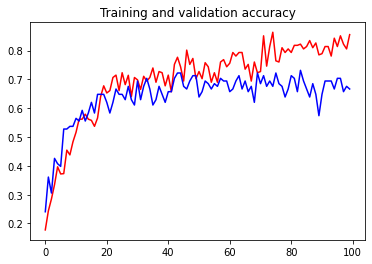

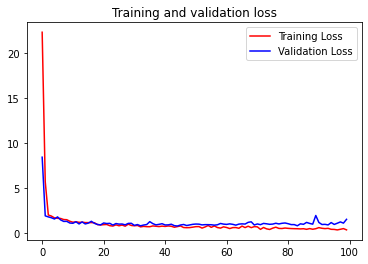

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predicting Dance Forms

In [ ]:
test=pd.read_csv('dataset/test.csv')

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
test_ag=test_datagen.flow_from_dataframe(test,directory='dataset/test',x_col='Image',
                                           target_size=(400,250), class_mode=None,batch_size=12,shuffle=False)

Found 156 validated image filenames.


In [ ]:
classes=train_ag.class_indices
inv_map = {v: k for k, v in classes.items()}

In [ ]:
predicted_outputs=model.predict(test_ag)
predicted_outputs=np.argmax(predicted_outputs,axis=1)
predicted_outputs

array([6, 3, 6, 6, 0, 3, 0, 2, 3, 6, 1, 0, 7, 7, 6, 0, 6, 1, 5, 0, 6, 2,
       2, 6, 1, 2, 6, 0, 1, 0, 3, 3, 1, 0, 5, 6, 6, 6, 1, 6, 1, 1, 1, 7,
       0, 7, 6, 7, 2, 0, 5, 6, 0, 0, 1, 1, 4, 6, 3, 0, 2, 4, 0, 0, 1, 3,
       2, 0, 0, 0, 6, 6, 2, 7, 6, 2, 0, 0, 2, 1, 0, 1, 7, 6, 6, 0, 7, 1,
       4, 2, 4, 1, 1, 1, 6, 0, 7, 2, 0, 3, 6, 0, 1, 6, 1, 3, 2, 6, 4, 6,
       1, 2, 6, 6, 3, 6, 2, 2, 7, 3, 6, 0, 3, 5, 6, 5, 1, 5, 1, 6, 6, 5,
       0, 6, 4, 6, 6, 0, 0, 1, 7, 1, 4, 2, 3, 2, 3, 5, 4, 6, 5, 7, 7, 0,
       6, 7])

In [ ]:
predicted_outputs=[inv_map[i] for i in predicted_outputs]
predicted_outputs=pd.Series(data=predicted_outputs)

In [ ]:
final=pd.merge(test,predicted_outputs.rename('target'),left_index=True, right_index=True)

In [ ]:
final.to_csv("results.csv")